## Unsupervised Learning with Quantum Speedup
This notebook is an example of unsupervised learning on a quantum computer. The data used are from the iris data set.

Both classical and quantum methods are used to classify the iris dataset. First, the classical k-means clustering algorithm is implemented. Second, the max-cut problem is mapped to an Ising Hamiltonian and solved using QAOA. The [edX](https://www.edx.org) quantum machine learning course [[1](#1)], a kaggle tutorial [[2](#2)] on k-means, a qiskit tutorial [[3](#3)] on max-cut, and the paper *Unsupervised Machine Learning on a Hybrid Quantum Computer* [[4](#4)] were helpful aids in constructing this notebook and make for interesting reading.

In [1]:
import numpy as np
from numba import jit
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.cluster import KMeans

In [2]:
# Import Iris dataset
df = pd.read_csv('Data/iris.csv')
df.drop(["Id"],axis=1,inplace=True)
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Let's look at the data by species to get an idea of how we expect the classical and quantum algorithms to classify the data. Since the quantum computer will be simulated on my laptop, <strong>let's reduce the dataset</strong> for a faster run time.

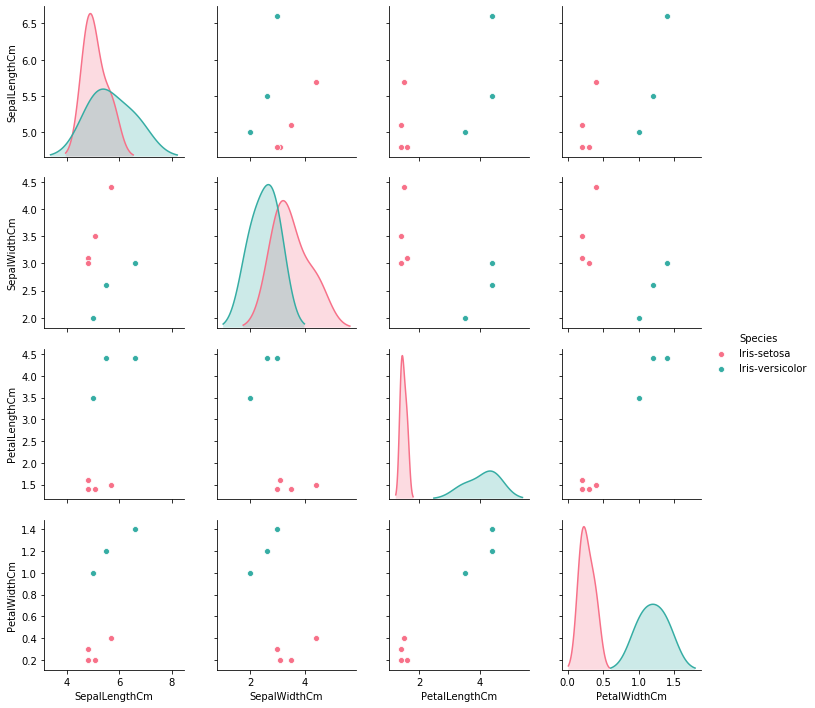

In [3]:
# Generate subset of data with fewer data points
df_sub = df.iloc[::15,:].reset_index(drop=True)

# Constrain data to only 2 species
df_sub = df_sub.loc[(df_sub['Species'] == 'Iris-setosa') | (df_sub['Species'] == 'Iris-versicolor')]

# View data with known labels as a control to compare future classifications done by k-means and max-cut
sns.pairplot(data=df_sub,hue="Species",palette="husl")
plt.show()

# A Classical Approach
The k-means algorithm is an unsupervised machine learning method. K-means will cluster data into k groups based on minimizing each cluster's sum-of-sqaures also known as inertia

$$
\sum_{i=0}^{n} \min_{u_j \in C}(\lvert\lvert x_i - u_j\rvert\rvert^2)
$$

where $\mu_j$ is the mean of the jth cluster within the set $C$ of clusters.
(see scikit-learn's [clustering userguide](https://scikit-learn.org/stable/modules/clustering.html#k-means) for more details). The optimal number of clusters k is known for this data ($k=2$) since the reduced dataset only contains two species. However, we will predent that is unknown. Comparison between the actual species label and how k-means clusters the data will be a performance metric for this and the quantum approach. Since the optimal k is unknown, let's use the [elbow rule](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) to determine the optimal k.

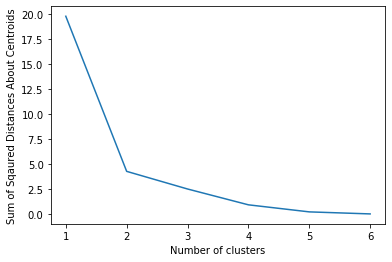

In [4]:
# Use k-means as classical unsupervised learning method (compare to quantum method later)

# Remove Iris labels (otherwise it's not unsurpervised learning!)
data = df_sub.loc[:,['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']]
data.head()

# Use elbow rule to choose optimal k
dis = []
K = range(1,len(data))
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
    dis.append(kmeans.inertia_)

# Visualize Optimal k
plt.plot(K,dis)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Sqaured Distances About Centroids')
plt.show()

Looks like 2 (maybe 3?) is most elbowy and thus the optimal k. Let's fit then visualize the k-means algorithm now with the optimal k.

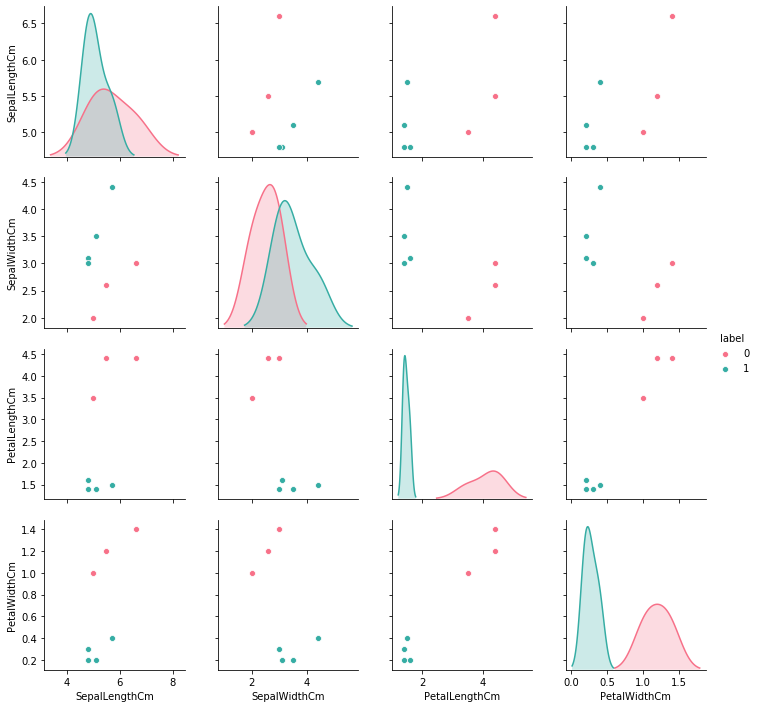

In [5]:
# Use optimal k for final k-means model
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=0).fit(data)

# Add k-means labeling to dataframe for later comparison
df_sub['label'] = kmeans.labels_

# Visualize grouping done by k-means algorithm.
sns.pairplot(data=df_sub,hue='label',palette="husl",vars=df_sub.columns[:-2])
plt.show()

The plots looks identical to the reduced dataset. This is directly confirmed below where we see Iris-setosa is mapped 100% to class 1 and Iris-versicolor is mapped 100% to class 0.

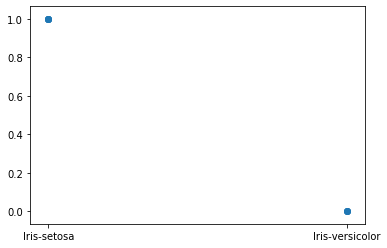

"Average" label classification:
Species
Iris-setosa        1.0
Iris-versicolor    0.0
Name: label, dtype: float64


In [6]:
# Calculate percent of miss labeled data points
plt.scatter(df_sub['Species'], df_sub['label'])
plt.show()

print('\"Average\" label classification:')
print(df_sub.groupby(['Species']).sum()['label'] / df_sub.groupby(['Species']).count()['label'])

# The Iris-setosa and Iris-virginica data points were all correctly clustered into different groups.
# About 6% of the Iris-versicolor data were incorrectly clustered with Iris-setosa.

With a k = 2, the k-means algorithm clustering is 100% accurate on this subset of the iris dataset! The elbow rule pulled through! Let's see how the quantum computer fairs.

# Quantum Approach

One approach to unsurpervised quantum machine learning is to map the problem to a graph optimization problem (specifically max-cut). The graph optimization problem can then be mapped to a cost Hamiltonian, which can quickly be solved by a quantum computer.

## Mapping clustering to discrete optimization

The full Iris dataset has points $\{x_i\}_{i=1}^{150}$ lying in a four-dimensional space $\mathbb{R}^4$. There are different ways to measure which data points are close to one another and which ones are distant. We will simply use the $l^2\text{-norm}$ (i.e. vector magnitude). Again, we'll be using a subset of the data to facilitate fast simulation of a quantum computer. The first step in mapping to a graph is calculating the pairwise "distances" between each data point. These distances will weight the edges of the graph between each data point.

In [7]:
import itertools

# Remove Iris labels
data = df_sub.loc[:,['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']]

# Get number of data entries
n_instances = len(data)

# Convert dataframe into array
data_array = data.values

# Compute pairwise L2-norms
w = np.zeros((n_instances, n_instances))
for i, j in itertools.product(*[range(n_instances)]*2):
    w[i, j] = np.linalg.norm(data_array[i]-data_array[j])

print('Weight matrix size:',w.shape)

Weight matrix size: (7, 7)


To seperate the graph into clusters, the graph is cut with a [max-cut](https://en.wikipedia.org/wiki/Maximum_cut): meaning the graph is seperated in two while maximizing total weight of the 'cut' edges. This is an NP-hard problem. However, it maps to an Ising model, so there is a quantum speedup! [[4](#4)]

We can interpret the output of the Ising model as follows. The are spin variables $\sigma_i \in \{-1, +1\}$ take on the value $\sigma_i = +1$ for data in cluster 1, and $\sigma_i = -1$ for data in cluster 2! The cost of one cut between nodes $i$ and $j$ is the edge's weight $w_{ij}$ that lies between them. In seperating the graph into two sets of nodes ($V_1$ for cluster 1 and $V_2$ for cluster 2), the total weight cut will be

$$
\sum_{i\in V_1, j\in V_2} w_{ij}.
$$

Assuming a fully connected graph and accounting for symmetries of $w_{ij}$ ($w_{ij} = w_{ji}$), the sum is expanded as
$$
\frac{1}{4}\sum_{ij} w_{ij} - \frac{1}{4} \sum_{ij} w_{ij} \sigma_i \sigma_j
$$
$$
= \frac{1}{4}\sum_{ij} w_{ij} (1- \sigma_i \sigma_j).
$$                 

By taking the negative of this, we can explicity see it's connection to the Ising Hamiltonian

$$
H_{ising} = \sum_{ij}J_{ij}\sigma_i\sigma_j - h\sum_{i}\sigma_i.
$$

Now that the max-cut weight is mapped to the Ising Hamiltonian, a quantum computer can efficiently find the max-cut by finding the ground state of $H_{ising}$. Note, the Ising model is typically a sum over all <strong>neighboring</strong> pairs of sides (or nodes) $\sum_{<ij>}$. Since the graph is fully connected (or can be made fully connected by adding edges of weight zero), $\sum_{<ij>}$ is identical to $\sum_{ij}$.

# Solving the max-cut problem by QAOA

[Qiskit](https://qiskit.org) already has max-cut and QAOA neatly organized into packages, making the quantum optimization straight forward.

In [8]:
# Quantum Computing packages
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import QAOA
from qiskit.aqua.translators.ising import max_cut
from qiskit.aqua.components.optimizers import COBYLA

In [9]:
p = 2  # Number of adiabatic steps must be >= 1
optimizer = COBYLA()  # Arbitrary selection
qubit_ops, offset = max_cut.get_max_cut_qubitops(w)
qaoa = QAOA(qubit_ops, optimizer, p)

In [10]:
# This may take a minute or two to run
backend = BasicAer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, shots=1)
result = qaoa.run(quantum_instance)

# Extract clustering solution from result variable
x = max_cut.sample_most_likely(result['eigvecs'][0])

# Show results
print('energy:', result['energy'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

energy: -8.110737682702117
max-cut objective: -32.341544258456466
solution: [0. 0. 0. 0. 1. 1. 1.]
solution objective: 38.190683893929574


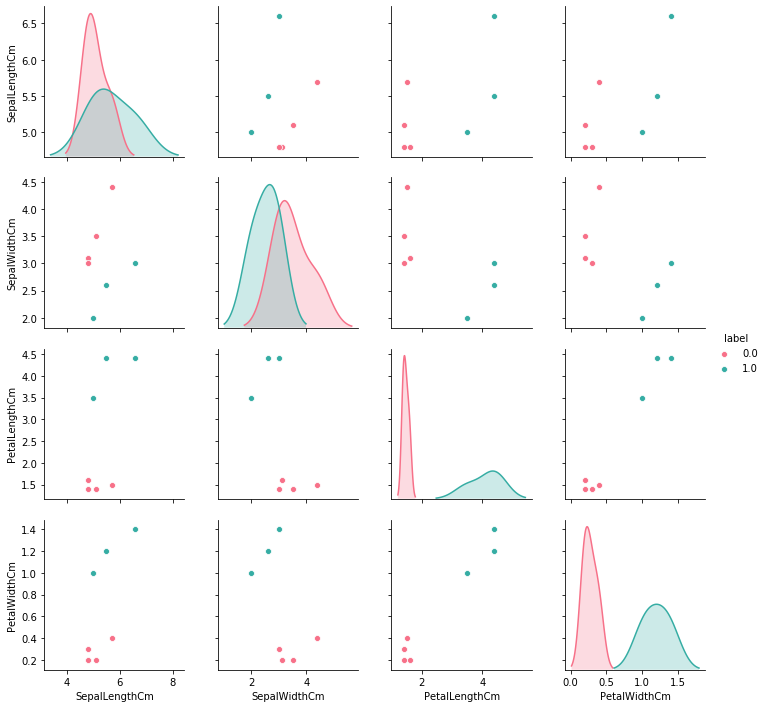

"Average" label classification:
Species
Iris-setosa        0.0
Iris-versicolor    1.0
Name: label, dtype: float64


In [11]:
# Extract labels and include them in df_sub
labels = pd.DataFrame(max_cut.get_graph_solution(x),columns=['label'])
df_sub['label'] = labels

# Show data by classification
sns.pairplot(data=df_sub,hue='label',palette="husl",vars=df_sub.columns[:-2])
plt.show()

# Display sum of classification label
print('\"Average\" label classification:')
print(df_sub.groupby(['Species']).sum()['label'] / df_sub.groupby(['Species']).count()['label'])

The plots looks identical to the reduced dataset--again! This is directly confirmed by the "average" label classification. All of Iris-setosa is mapped to class 0 and all of Iris-versicolor is mapped to class 1.

# References

[1] Edx. (accessed 2019). [Quantum Machine Learning](https://www.edx.org/course/quantum-machine-learning-2). <a id='2'></a>

[2] Unsupervised Learning on Iris. (accessed 2019). [Kaggle Tutorial](https://www.kaggle.com/efeergun96/unsupervised-learning-on-iris). <a id='3'></a>

[3] Max-Cut. (accessed 2019). [Qiskit Tutorial](https://github.com/qiskit-community/qiskit-qcgpu-provider/blob/master/examples/aqua/Max-Cut.ipynb).  <a id='4'></a>

[4] Otterbach, J. S., et al. (2017). [Unsupervised Machine Learning on a Hybrid Quantum Computer](https://arxiv.org/abs/1712.05771). *arXiv:1712.05771*. <a id='1'></a>

# Future work *(currently in progress)*
Imagine we did not reduce the Iris dataset. Not only would there be too many entries for the quantum computer simulator to solve quickly, but there is the fundamental problem of classifing the output into **3** groups. How do we use max-cut ang QAOA to classify data into more than 2 groups?

## Top-Down Hierarchical
One solution is to a top-down hierarchial clustering method: (0) solve the max-cut problem on the entire dataset, (1) assume the two new groups are whole clusters or groups of whole clusters, repeat (0)-(1) with the new group, stop based on criteria.

The criteria for when to stop can be evaulated by the cut edges, or "energy", values.

In [12]:
# Compute pairwise L2-norms
import itertools

def calc_w(data_array):
    n_instances = data_array.shape[0]
    w = np.zeros((n_instances, n_instances))
    for i, j in itertools.product(*[range(n_instances)]*2):
        w[i, j] = np.linalg.norm(data_array[i]-data_array[j])
    return w

# w elements are the negative exponential of the l2-norm
def calc_w_exp_decay(data_array):
    n_instances = data_array.shape[0]
    w = np.zeros((n_instances, n_instances))
    length_scale = np.mean(data_array)  # length_scale is preferably shorter than average distance
    for i, j in itertools.product(*[range(n_instances)]*2):
        if i == j:
            w[i, j] = 0
        else:
            w[i, j] = np.exp(np.linalg.norm(data_array[i]-data_array[j]) / length_scale)
    return w

In [13]:
# Remove Iris labels and Sepal dimensions
data_full = df.loc[:,['PetalLengthCm','PetalWidthCm','SepalLengthCm','SepalWidthCm',]]

# Reduce number of data points, will be removed later
# Dataframe with species labels
df_sub = df[::15]
# Dataframe without species lables
data_sub = data_full[::15]
data_sub

,PetalLengthCm,PetalWidthCm,SepalLengthCm,SepalWidthCm
0,1.4,0.2,5.1,3.5
15,1.5,0.4,5.7,4.4
30,1.6,0.2,4.8,3.1
45,1.4,0.3,4.8,3.0
60,3.5,1.0,5.0,2.0
75,4.4,1.4,6.6,3.0
90,4.4,1.2,5.5,2.6
105,6.6,2.1,7.6,3.0
120,5.7,2.3,6.9,3.2
135,6.1,2.3,7.7,3.0


In [24]:
# Load IBM cloud computing options so simulations run faster
from qiskit import IBMQ

IBMQ.load_account()  # Load account from disk
provider = IBMQ.get_provider(group='open')
provider.backends()  # See available backends

data_sub

/Users/Razander/anaconda3/lib/python3.6/site-packages/qiskit/providers/ibmq/ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


,PetalLengthCm,PetalWidthCm,SepalLengthCm,SepalWidthCm
0,1.4,0.2,5.1,3.5
15,1.5,0.4,5.7,4.4
30,1.6,0.2,4.8,3.1
45,1.4,0.3,4.8,3.0
60,3.5,1.0,5.0,2.0
75,4.4,1.4,6.6,3.0
90,4.4,1.2,5.5,2.6
105,6.6,2.1,7.6,3.0
120,5.7,2.3,6.9,3.2
135,6.1,2.3,7.7,3.0


In [22]:
# Number of iterations to turn every datapoint into its own cluster
r = int(np.log2(len(data_sub)))
data = data_sub.copy()

# QAOA hyperparameters
p = 1  # Number of adiabatic steps must be >= 1
optimizer = COBYLA()  # Arbitrary selection
backend_ibm = provider.get_backend('ibmq_qasm_simulator')  # Simulate using IBM's cloud service
backend_local = BasicAer.get_backend('statevector_simulator')  # Simulate using local machine

for i in range(0,r):
    # Initialize 'labels' column for future QAOA output
    data['cluster_'+str(i)] = np.nan
    data['cut_'+str(i)] = np.nan
    
    # Select subsets of data based on clustering from previous execution
    dfs = []
    if i != 0:
        cluster_range = data['cluster_'+str(i-1)].unique()
        for j in cluster_range:
            print('cluster_'+str(i-1),j)
            dfs.append(data[data['cluster_'+str(i-1)] == j][data.columns[:4]])
    else:
        dfs.append(data[data.columns[:4]])

    for j, df_part in enumerate(dfs):
        df__part_array = df_part.values
        w = calc_w(df__part_array)  # Calculate pairwise distances between points
        #print('w size:',w.shape,w)
        #w = calc_w_exp_decay(part_array)  # Calculate pairwise distances between points
        # Execute algorithm
        qubit_ops, offset = max_cut.get_max_cut_qubitops(w)
        qaoa = QAOA(qubit_ops, optimizer, p)
        if w.shape[0] > 10:
            backend = backend_ibm
        else:
            backend = backend_local
        quantum_instance = QuantumInstance(backend, shots=1)
        result = qaoa.run(quantum_instance)

        # Extract results
        x = max_cut.sample_most_likely(result['eigvecs'][0])

        # Put labels back into full data array. Labels must be unqiue each iteration
        df_part['cluster_'+str(i)] = max_cut.get_graph_solution(x) + 2*j
        df_part['cut_'+str(i)] = max_cut.max_cut_value(x, w)
        
        data.update(df_part)

    print('Iteration',i+1,'of',r,'completed')

/Users/Razander/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Iteration 1 of 3 completed
cluster_0 1.0
cluster_0 0.0
Iteration 2 of 3 completed
cluster_1 1.0
cluster_1 0.0
cluster_1 2.0
cluster_1 3.0
Iteration 3 of 3 completed


In [23]:
# Include results in df_sub dataframe for analysis
for i in range(0,r):
    df_sub.loc[:,'cluster_'+str(i)] = data.loc[:,'cluster_'+str(i)]
    df_sub.loc[:,'cut_'+str(i)] = data.loc[:,'cut_'+str(i)]
df_sub

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,cluster_0,energy_0,cluster_1,energy_1,cluster_2,energy_2,cut_0,cut_1,cut_2
0,5.1,3.5,1.4,0.2,Iris-setosa,1.0,-83.437224,1.0,-3.811835,0.0,-1.104536,105.614393,4.397326,1.104536
15,5.7,4.4,1.5,0.4,Iris-setosa,1.0,-83.437224,1.0,-3.811835,1.0,-1.104536,105.614393,4.397326,1.104536
30,4.8,3.1,1.6,0.2,Iris-setosa,1.0,-83.437224,0.0,-3.811835,2.0,-0.244926,105.614393,4.397326,0.244949
45,4.8,3.0,1.4,0.3,Iris-setosa,1.0,-83.437224,0.0,-3.811835,3.0,-0.244926,105.614393,4.397326,0.244949
60,5.0,2.0,3.5,1.0,Iris-versicolor,0.0,-83.437224,2.0,-20.447287,5.0,-3.125235,105.614393,26.656601,3.336684
75,6.6,3.0,4.4,1.4,Iris-versicolor,0.0,-83.437224,2.0,-20.447287,4.0,-3.125235,105.614393,26.656601,3.336684
90,5.5,2.6,4.4,1.2,Iris-versicolor,0.0,-83.437224,2.0,-20.447287,4.0,-3.125235,105.614393,26.656601,3.336684
105,7.6,3.0,6.6,2.1,Iris-virginica,0.0,-83.437224,3.0,-20.447287,7.0,-1.825878,105.614393,26.656601,2.091249
120,6.9,3.2,5.7,2.3,Iris-virginica,0.0,-83.437224,3.0,-20.447287,6.0,-1.825878,105.614393,26.656601,2.091249
135,7.7,3.0,6.1,2.3,Iris-virginica,0.0,-83.437224,3.0,-20.447287,7.0,-1.825878,105.614393,26.656601,2.091249


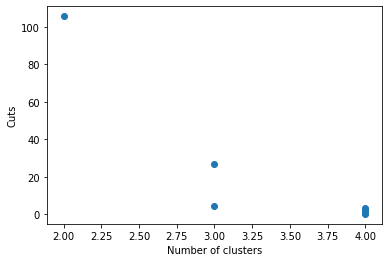

In [29]:
# Elbow rule varient; I dub the "Elbow Pit Rule": stop dividing data at with relatively high cut value
# Instead of picking the lower points (the elbow) we will see the overall shape, but we want the other side of the arm
# which is the elbow pit
# For this case the stop criteria is at three clusters with the 3rd cluster from the 26 cut not the 4 cut.
cuts = [105.61,26.66,4.40,2.09,3.34,0.24,1.10]
clusters = [2,3,3,4,4,4,4]
plt.scatter(clusters,cuts)
plt.xlabel('Number of clusters')
plt.ylabel('Cuts')
plt.show()

## Random Partitioning Method
One solution is to partition the data into m groups, which are randomly assigned. The max-cut problem would be solved using QAOA for each partition leaving $2 m$ clusters. By repeating this process data classifications will begin to overlap. For example, the first run may say $x_1$ is in cluster $2$ and $x_10$ is in cluster $3$. A second run may say $x_1$ and $x_10$ are both in cluster $20$. We would then conclude clusters $2$, $3$, and $20$ are the same cluster, thus lowering the total number of clusters.

This approach starts with an upper bound on the number of clusters $2m$ where m is the number of partitions. Upon each iteration, the $2m$ is reduced until--in worse case scenario--m iterations have determined there are only 2 clusters in the full dataset.

There are a few limitations to this procedure. First, there is a lower bound on the number of clusters $2 m$. In this scenario each partition would be only $2$ data points in which case each data point would be classified as independent leaving $2 m$ clusters with $1$ data point each. Second, the number of data points in each partition must be greater than $2$ for the concern just mentioned. The max-cut would always be between the two points because that's the only edge! I'd guess the more data points in the partition, the better, but that must be balanced with the number of partitions as mentioned in the first point.

Probably of a data point remaining in the same partition $1-\frac{1}{m}^r$ where m is the total number of partitions and r is number of iterations of data shuffle and QAOA execution on each partition.

In [ ]:
# Number of iterations
r = 1
data = df_sub1.copy()
# Number of partitions
parts = 1

# QAOA hyperparameters
p = 2  # Number of adiabatic steps must be >= 1
optimizer = COBYLA()  # Arbitrary selection
backend = provider.get_backend('ibmq_qasm_simulator')  # Simulate using IBM's cloud service
#backend = BasicAer.get_backend('statevector_simulator')  # Simulate using local machine
quantum_instance = QuantumInstance(backend, shots=1)

for i in range(0,r):
    # Shuffle data
    data = data.sample(frac=1)

    # Initialize 'labels' column for future QAOA output
    data['labels_'+str(i)] = np.nan
    data['energy_'+str(i)] = np.nan
    
    # Break data into m partitions (abitrary choice of m). Also remove 'labels_i' from data.
    partitions = np.array_split(data[data.columns[:4]], parts)

    for part in partitions:
        part_array = part.values
        w = calc_w(part_array)  # Calculate pairwise distances between points
        #w = calc_w_exp_decay(part_array)  # Calculate pairwise distances between points
        # Execute algorithm
        qubit_ops, offset = max_cut.get_max_cut_qubitops(w)
        qaoa = QAOA(qubit_ops, optimizer, p)
        result = qaoa.run(quantum_instance)

        # Extract results
        x = max_cut.sample_most_likely(result['eigvecs'][0])

        # Put labels back into full data array. Labels must be unqiue each iteration
        part['labels_'+str(i)] = max_cut.get_graph_solution(x) + 2*i
        part['energy_'+str(i)] = result['energy'] + offset
        
        data.update(part)

    print('Iteration',i+1,'of',r,'completed')

In [ ]:
# Include results in df_sub dataframe for analysis
for i in range(0,r):
    df_sub1.loc[:,'labels_'+str(i)] = data.loc[:,'labels_'+str(i)]
    df_sub1.loc[:,'energy_'+str(i)] = data.loc[:,'energy_'+str(i)]
df_sub1

In [ ]:

# Number of iterations
r = 1
data = df_sub0.copy()
# Number of partitions
parts = 1

# QAOA hyperparameters
p = 2  # Number of adiabatic steps must be >= 1
optimizer = COBYLA()  # Arbitrary selection
#backend = provider.get_backend('ibmq_qasm_simulator')  # Simulate using IBM's cloud service
backend = BasicAer.get_backend('statevector_simulator')  # Simulate using local machine
quantum_instance = QuantumInstance(backend, shots=1)

for i in range(0,r):
    # Shuffle data
    data = data.sample(frac=1)

    # Initialize 'labels' column for future QAOA output
    data['labels_'+str(i)] = np.nan
    data['energy_'+str(i)] = np.nan
    
    # Break data into m partitions (abitrary choice of m). Also remove 'labels_i' from data.
    partitions = np.array_split(data[data.columns[:4]], parts)

    for part in partitions:
        part_array = part.values
        w = calc_w(part_array)  # Calculate pairwise distances between points
        #w = calc_w_exp_decay(part_array)  # Calculate pairwise distances between points
        # Execute algorithm
        qubit_ops, offset = max_cut.get_max_cut_qubitops(w)
        qaoa = QAOA(qubit_ops, optimizer, p)
        result = qaoa.run(quantum_instance)

        # Extract results
        x = max_cut.sample_most_likely(result['eigvecs'][0])

        # Put labels back into full data array. Labels must be unqiue each iteration
        part['labels_'+str(i)] = max_cut.get_graph_solution(x) + 2*i
        part['energy_'+str(i)] = result['energy'] + offset
        
        data.update(part)

    print('Iteration',i+1,'of',r,'completed')

In [ ]:
# Include results in df_sub dataframe for analysis
for i in range(0,r):
    df_sub0.loc[:,'labels_'+str(i)] = data.loc[:,'labels_'+str(i)]
    df_sub0.loc[:,'energy_'+str(i)] = data.loc[:,'energy_'+str(i)]
df_sub0

In [ ]:
# Plot Species vs energy labels
df_plot = pd.DataFrame()
df_plot['energies'] = df_sub[df_sub.columns[6::2]].mean(axis=1)
df_plot['Species'] = df_sub['Species']
df_plot.groupby('Species')['energies'].hist(bins=10)

In [ ]:
# Plot Species vs energy labels
df_plot = pd.DataFrame()
df_plot['energy_1'] = df_sub['energy_1']
df_plot['Species'] = df_sub['Species']
df_plot.groupby('Species')['energy_1'].hist(bins=10)

In [ ]:
# Do a max-cut on the energies from each iteration to pick which
# are the best at classifing the data as in the same cluster (high energy)
# or in a different cluster (low energy)?

# Doesn't work
'''np.abs(df_sub['energy_0'])

w = calc_w(np.abs(df_sub['energy_0'].values))

p = 2  # Number of adiabatic steps must be >= 1
optimizer = COBYLA()  # Arbitrary selection
qubit_ops, offset = max_cut.get_max_cut_qubitops(w)
qaoa = QAOA(qubit_ops, optimizer, p)

# This may take a minute or two to run
#backend = provider.get_backend('ibmq_qasm_simulator')  # Simulate using IBM's cloud service
backend = BasicAer.get_backend('statevector_simulator')  # Simulate using local machine
quantum_instance = QuantumInstance(backend, shots=1)
result = qaoa.run(quantum_instance)

# Extract clustering solution from result variable
x = max_cut.sample_most_likely(result['eigvecs'][0])

# Show results
print('energy:', result['energy'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))'''

In [ ]:
# Determine clusters by taking the highest energy pair as belonging to the same cluster
# and lowest energy pair as belonging to different clusters

# Initialize final clustering id to NaN
df_sub['class'] = np.nan

# Initialize classification id
clust_id = 0
clust_dict = {}

for i in range(0,r):
    energy_bound = df_sub['energy_'+str(i)].min()
    for j, row in df_sub.loc[df_sub['energy_'+str(i)] <= energy_bound,'class'].iteritems():
        if np.isnan(row):
            df_sub.at[j,'class'] = clust_id
        else:
            # Join clusters
            print('not nan. was cluster:',row)
            # Note cluster id is the same as current cluster id
            clust_dict[clust_id] = row
        clust_id += 1
df_sub

In [ ]:
clust_dict

In [ ]:
df_sub

In [ ]:
# Sum energies across columns
df_sub[df_sub.columns[6::2]].sum(axis=0)

In [ ]:
# Display sum of classification label
print('\"Average\" label classification:')
print(df_sub.groupby(['Species']).sum()['labels_0'] / df_sub.groupby(['Species']).count()['labels_0'])
print(df_sub.groupby(['Species']).sum()['labels_1'] / df_sub.groupby(['Species']).count()['labels_1'])

In [ ]:
min_energy = df_sub[df_sub.columns[-3:]].sum(axis=1).min()
max_energy = df_sub[df_sub.columns[-3:]].sum(axis=1).max()
dif_energy = max_energy - min_energy
mask1 = df_sub[df_sub.columns[-3:]].sum(axis=1) < (min_energy + dif_energy/3)
mask2 = df_sub[df_sub.columns[-3:]].sum(axis=1) < (min_energy + 2*dif_energy/3)
mask3 = df_sub[df_sub.columns[-3:]].sum(axis=1) > (min_energy + 2*dif_energy/3)

In [ ]:
df_sub[mask1]
df_sub[mask2][~mask1]
df_sub[mask3]

In [ ]:
dif_energy

In [ ]:
min_energy

In [ ]:
max_energy